# Analyse Customer Segment by Unsupervised Learning Model
    (1 PCA
    (2 K-means
    (3 Answer the question:
        Which customer attributes are significantly differentiating from the non-customer population?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle

In [2]:
from src.model_pipeline import clean_data

In [3]:
#gather data for unsupervised learning
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Preprocessing
- Apply the wrangling method in data_wrangling section

In [4]:
azdias_clean = clean_data(azdias)

Dataset has 0 missing value.


In [5]:
customers_clean = clean_data(customers)
customers_clean_nolabel = customers_clean.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

Dataset has 0 missing value.


In [6]:
# set label for customer and non-customer
azdias_clean['y'] = 0
customers_clean_nolabel['y'] = 1
df = azdias_clean.append(customers_clean_nolabel, ignore_index=True)
X = df[[col for col in df.columns if col not in ['LNR', 'y' ]]]
y = df['y']

## PCA
- Utilize PCA algorithm to reduce dimension

In [7]:
# Standar Scaler before apply PCA
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [8]:
ratio_list = []

# Get explained variance of differenct n component
for i in range(150):
    pca = PCA(n_components=i+1)
    pca.fit(X_norm)
    explained_variance_ratio_sum = pca.explained_variance_ratio_.sum()
    ratio_list.append(explained_variance_ratio_sum)
    print(f'{i+1} components explains {explained_variance_ratio_sum} of variance.')
    
file = open("src/pca_explain_variance.plk", "wb")
pickle.dump(ratio_list, file)
file.close()

1 components explains 0.3232660001374566 of variance.
2 components explains 0.39181392639894097 of variance.
3 components explains 0.4486724930407141 of variance.
4 components explains 0.4904627596282453 of variance.
5 components explains 0.5216566842599919 of variance.
6 components explains 0.549352820923742 of variance.
7 components explains 0.5693127397972075 of variance.
8 components explains 0.5825148634531147 of variance.
9 components explains 0.594445182306021 of variance.
10 components explains 0.6053598452915281 of variance.
11 components explains 0.6153214691303631 of variance.
12 components explains 0.6245151114921025 of variance.
13 components explains 0.6335266612331479 of variance.
14 components explains 0.6414971495872472 of variance.
15 components explains 0.6485819615747872 of variance.
16 components explains 0.6552375513195329 of variance.
17 components explains 0.6615589661064892 of variance.
18 components explains 0.6677606601672604 of variance.
19 components explai

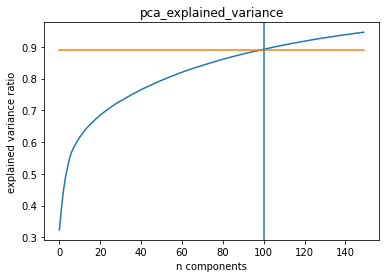

0.8910523188376421

In [9]:
# draw the chart to find the optimal n_components
file = open("src/pca_explain_variance.plk",'rb')
pca_explain_variance = pickle.load(file)
plt.title('pca_explained_variance')
plt.ylabel('explained variance ratio')
plt.xlabel('n components')
plt.plot(pca_explain_variance)
plt.plot(np.full(len(pca_explain_variance), pca_explain_variance[99]))
plt.axvline(x=100)
plt.show()
pca_explain_variance[99]

#### As the graph shows, 100 component can explain 85% variance, so we take reduce our deminsion to 100.

## K-Means
 - Utilize K-means to divide population and find the attributes representing company customer

In [10]:
# reduce dimension before clustering
pca = PCA(n_components=100)
reduced_data = pca.fit_transform(X_norm)

In [12]:
mss_list = []

# Get MSS of differenct K
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, n_jobs=-1)
    kmeans.fit(reduced_data)
    mss = kmeans.inertia_
    mss_list.append(mss)
    print(f'{k} clusters sum of distances is {mss}.')
    
file = open("src/kmean_mss.plk", "wb")
pickle.dump(mss_list, file)
file.close()

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


2 clusters sum of distances is 195580063.27163574.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


3 clusters sum of distances is 179609257.02568966.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


4 clusters sum of distances is 163006854.33144003.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


5 clusters sum of distances is 155945668.32317123.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


6 clusters sum of distances is 150095858.24970144.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


7 clusters sum of distances is 145463059.34456003.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


8 clusters sum of distances is 142299940.1677625.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


9 clusters sum of distances is 140138668.0081683.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


10 clusters sum of distances is 138074267.00386187.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


11 clusters sum of distances is 134794898.5498976.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


12 clusters sum of distances is 133173361.43079346.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


13 clusters sum of distances is 131857517.11228769.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


14 clusters sum of distances is 130815107.46501596.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


15 clusters sum of distances is 129959704.21107061.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


16 clusters sum of distances is 129333788.9488628.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


17 clusters sum of distances is 128340630.47934186.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


18 clusters sum of distances is 127644168.5727628.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


19 clusters sum of distances is 126983206.45634088.


/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


20 clusters sum of distances is 125602919.96320498.


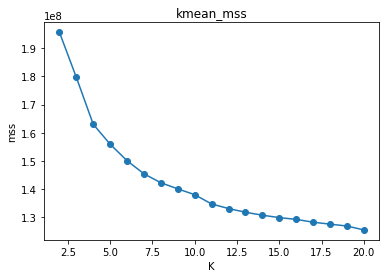

In [13]:
# Draw the mss chart to find the optimal K
file = open("src/kmean_mss.plk",'rb')
kmean_mss = pickle.load(file)
plt.title('kmean_mss')
plt.ylabel('mss')
plt.xlabel('K')
plt.plot(range(2,21), kmean_mss, '-o')
plt.show()

#### - Select 4 groups according to elblow theory.
#### - Try 17 groups if 5 not working because the curve start to flat at 17

In [21]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(reduced_data)
y_pred = kmeans.predict(reduced_data)

group_5_result = pd.DataFrame({
    'y_actual': y,
    'y_group': y_pred,
})

In [22]:
# Get the customer percentage in population
group_5_result_mean = group_5_result.groupby(['y_group']).mean()

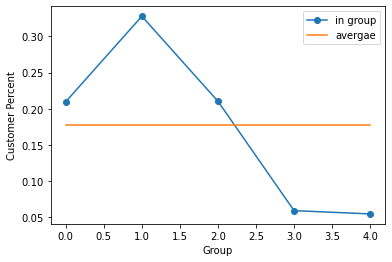

In [23]:
l1, = plt.plot(range(5), group_5_result_mean, '-o')
l2, = plt.plot(np.full(len(group_5_result_mean), group_5_result.mean()['y_actual']))
plt.legend(handles=[l1,l2],labels=['in group', 'avergae'])
plt.ylabel('Customer Percent')
plt.xlabel('Group')
plt.show()

 - Can not get clear info from above, so try 17 groups

In [27]:
kmeans = KMeans(n_clusters=17)
kmeans.fit(reduced_data)
y_pred = kmeans.predict(reduced_data)

group_17_result = pd.DataFrame({
    'y_actual': y,
    'y_group': y_pred,
})

In [28]:
group_17_result_mean = group_17_result.groupby(['y_group']).mean()

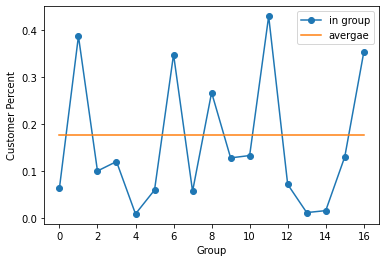

In [29]:
l1, = plt.plot(range(17), group_17_result_mean, '-o')
l2, = plt.plot(np.full(len(group_17_result_mean), group_17_result.mean()['y_actual']))
plt.legend(handles=[l1,l2],labels=['in group', 'avergae'])
plt.ylabel('Customer Percent')
plt.xlabel('Group')
plt.show()

 - Target group: 1, 11
 - Non Target Group: 4, 13, 14

### Check first 10 component in target group and non target group

In [30]:
def pca_cluster_centers_in_group(group_number, target_color, component_number= 10):
    """Draw the cluster mean of each variable compared with other groups
    
    Args:
    group_number=int, the number of group need to be hightlighted
    target_color='str', the highlight color
    component_number=int, variable number show in the chart
    
    Returns:
    fig=plt.figure()
    
    """
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    for i in range(17):
        #target group
        if i == group_number:
            color =  target_color
            l1, = ax.plot(kmeans.cluster_centers_[i, :component_number], color)
        else:
            color = 'lightgrey' 
            l2, = ax.plot(kmeans.cluster_centers_[i, :component_number], color)

    lmean, = ax.plot(kmeans.cluster_centers_.mean(axis=1)[:component_number], 'black')
    plt.legend(handles=[l1,l2, lmean],labels=['target', 'other', 'mean'])
    ax.set_title('Group' + str(group_number))
    ax.set_ylabel('cluster_centers_')
    ax.set_xlabel('component')

    return fig

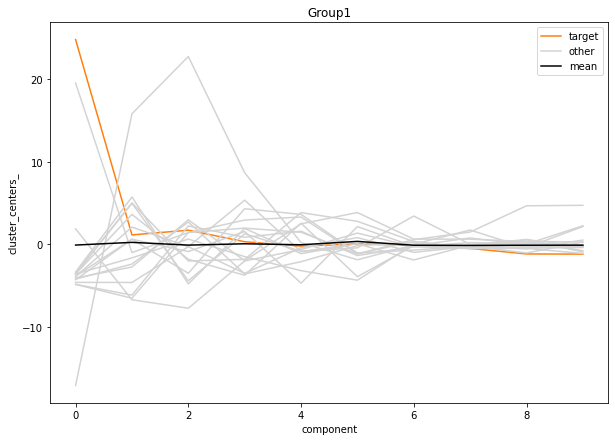

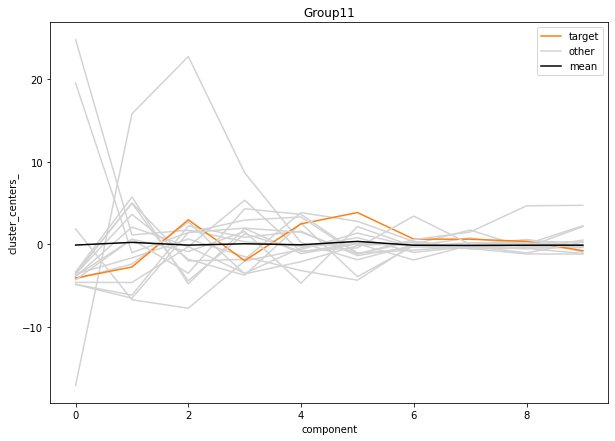

In [31]:
#check cluster center of target group
for group_number in [1, 11]:
    pca_cluster_centers_in_group(group_number, 'tab:orange')

Only group 12 provide meaning insights.

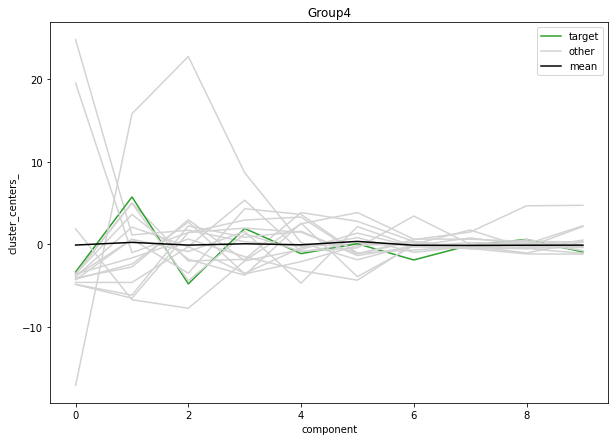

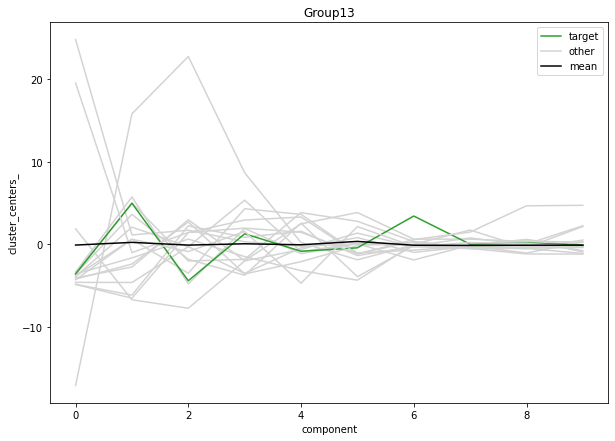

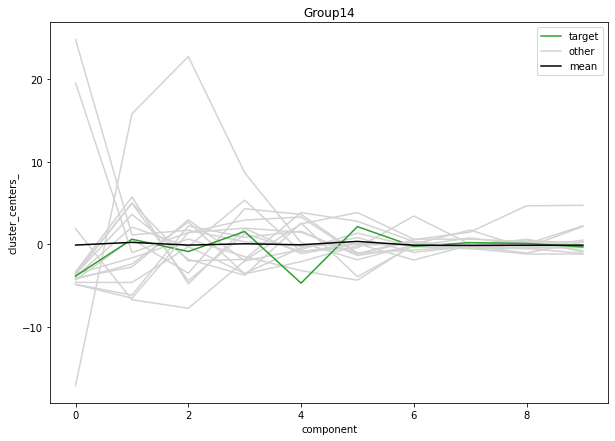

In [33]:
#check cluster center of non-target group
for group_number in [4, 13, 14]:
    pca_cluster_centers_in_group(group_number, 'tab:green')

#### Orange line is target group, green line is non-target group, can not get meaningful result because of different variance in each group. 
But Group 12 give us the insights that this target group have high first pca component value, so we  dig into the loading of this component.

In [36]:
# Find the loading in the group
component_number = 0
pd.DataFrame({
    'Attribute': [col for col in df.columns if col not in ['LNR', 'y' ]],
    'Loading': pca.components_.T[:, component_number],
    'Abs_loading': abs(pca.components_.T[:, component_number])
}).sort_values(by='Loading', ascending=False).head(10)

,Attribute,Loading,Abs_loading
249,KOMBIALTER,0.072648,0.072648
57,FINANZ_UNAUFFAELLIGER,0.051500,0.051500
53,FINANZ_ANLEGER,0.044787,0.044787
289,SEMIO_REL,0.043773,0.043773
283,SEMIO_KRIT,0.040791,0.040791
32,D19_KONSUMTYP_MAX,0.033817,0.033817
12,CJT_GESAMTTYP,0.032606,0.032606
15,CJT_TYP_2,0.032117,0.032117
27,D19_GESAMT_DATUM,0.030479,0.030479
56,FINANZ_SPARER,0.029847,0.029847


## Answer the question:
    Which customer attributes are significantly differentiating from the non-customer population?

 > From the loading we can find that our target customers are the people who have **frequent transaction avtivities**.